# Implementaion of L-layer Neural Network from Scratch

## 1. Define Helper functions for General L-layer Neural Network
These functions can be used to define NN with different configurations for other dataset as well. 
- Introduction
- Initialize Parameters(W,b)
- Forward Propagation
      - [Linear -> Relu] *(L-1 times)   ->   [Linear -> Sigmoid] 
- Cost function
- Backward Propagation
- Parameters update


## 2. Use Helper functions for Image Classification
- Define NN Configuration
- Import Dataset
- Train NN (Forward propagation, Backward propagation, Weights Update)
- Cache Weights
- Test NN on test Dataset

# 1. Defining Helper Functions for General L-layer NN

## 1.1 Introduction
To build a L-layer NN, we need some helper function which will be useful for implementing a simple NN. These will be general function can be used with other dataset as well.
<img src="images/first.jpg" style="width:800px;height:450px;">


### Dimensions
- **Zi = Wi . A_previous  + bi**
- **Ai = activation_funtion(Zi)**
    - Wi: (no. of units in current layer, no. of units in previous layer)
    - bi: (no. of units in current layer, 1)
    - Ai-1: (no. of units in previous layer, ?)
    - Zi and Ai: (no. of units in current layer, ?)
    - X (Input): (Features, (Batch ?))

## 1.2 Initialization 

Initialize parameters (W & b) with random values. These are the learnable parameters which will try to get their best values during training.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)

In [2]:
def initialize_parameters(layerdims):
    '''layerdims: List containing no. of units in each layer
    
    Returns:
    parameters: A dict consist of all learnable parameters (W1,b1, W2,b2, ...)
    '''
    parameters={}
    L = len(layerdims)
    for i in range(1, L):
        parameters["W"+str(i)] = np.random.randn( layerdims[i], layerdims[i-1]) * 0.1
        parameters["b"+str(i)] = np.zeros( (layerdims[i],1))
        
    return parameters

## 1.3 Forward Propagation

- for L-1 layer (ie. 1,2,3...L-1)
    - Linear -> Activation(Relu)   
- for L th layer (ie. last layer)
    - Linear -> Activation(sigmoid)
$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$
$$A = activation(Z)$$
where $A^{[0]} = Input matrix(X)$. 

    

In [3]:
def forward(A_prev, W, b, activation):
    ''' Forward Propagation for Single layer
    A_prev: Activation from previous layer (size of previous layer, Batch_size)
        A[0] = X
    W: Weight matrix (size of current layer, size of previous layer)
    b: bias vector, (size of current layer, 1)
    
    Returns:
    A: Output of Single layer
    cache = (A_prev,W,b,Z), these will be used while backpropagation
    '''
    # Linear 
    Z = np.add( np.dot(W,A_prev), b)
    
    # Activation Function 
    if activation== "sigmoid":
        A=1/(1+np.exp(-Z))
        
    if activation== "relu":
        A = np.maximum(0,Z)
        
    cache=(A_prev,W,b,Z)
    
    return A, cache 

In [4]:
def L_layer_forward(X, parameters, layerdims):
    ''' Forward propagation for L-layer
     
     [LINEAR -> RELU]*(L-1)   ->    LINEAR->SIGMOID
     
     X: Input matrix (input size/no. of features, no. of examples/BatchSize)
     parameters: dict of {W1,b1 ,W2,b2, ...}
     layerdims: Vector, no. of units in each layer  (no. of layers,)
    
    Returns:
     y_hat: Output of Forward Propagation
     caches: (A_prev,W,b,Z) *(L-1 times , of 1,2,..L layers)
    '''
    caches=[]
    L =  len(layerdims)-1
    A = X
    
    
    # L[0] is units for Input layer
    # [LINEAR -> RELU]*(L-1)    Forward for L-1 layers 
    for l in range(1,L):
        A_prev = A
        A, cache=forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)
      
    # Forward for Last layer
    # [Linear -> sigmoid]
    y_hat, cache=forward(A, parameters["W"+str(l+1)], parameters["b"+str(l+1)], "sigmoid")
    caches.append(cache)
    
    return y_hat, caches
    

## 1.4 Cost function
Computing the cross-entropy cost $J$, : $$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) $$

In [5]:
def compute_cost(y_hat, Y):
    '''Computes the Loss between predicted and true label
    y_hat: Predicted Output (1, no. of examples)
    Y: Actual label vector consist of 0/1 (1, no. of examples)
    
    '''
    m = Y.shape[1]
    costt = np.add(  np.multiply(Y, np.log(y_hat)) ,  np.multiply(1-Y, np.log(1-y_hat))  ) 
    cost = (-1/m) * np.sum(costt, axis=1)
    
    return cost


## 1.5 Backward Propagation

$$ dAL = \frac{\partial \mathcal{J} }{\partial AL} = - (\frac{Y}{AL}+\frac{1-Y}{1-AL})$$

$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{J} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$


In [6]:
def backward(dA,  cache, activation):
    '''Backward propagation for single layer
    dz: Derivative of Cost wrt Z   (of current layer)
    cache: tuple of (A_prev,W,b,Z)
    
    Retuns:
    dW: Gradient of Cost wrt W, (having same shape as W)
    db: Gradient of Cost wrt b, (having same shape as b)
    dA_prev: Gradient of Cost wrt Activation (same shape as A_prev)
    '''
    A_prev,W,b,Z = cache
    m= A_prev.shape[1]
    
    # Computing derivative of Cost wrt Z
    
    # dA, Z, 
    if activation == "relu":
        dZ = np.array(dA, copy=True)
        dZ[Z <=0] =0
        
    if activation == "sigmoid":
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)
        
    
    # Computing derivative of Cost wrt A & W  & b
    dA_prev = np.dot(W.transpose(), dZ)
    dW = (1/m) * np.dot(dZ, A_prev.transpose())
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
   
    
    return dA_prev, dW, db

In [7]:
def L_layer_backward(y_hat, Y, caches, layerdims):
    ''' Backward Propogation from layer L to 1
    y_hat:  predicted output
    Y:      true values
    caches: list of caches stored while forward Propagation
                (A_prev,W,b,Z) *(L-1 times , of 1,2,..L-1 layers) with relu
                (A_prev,W,b,Z) (for layer L, with sigmoid)
    layerdims:List having no. of units in each layer 
    Returns:
    grads: A dict containing gradient (dA_i, dW_i, db_i), this will be used while updating parameters
    '''
    AL = y_hat 
    L = len(layerdims) -1
    grads={}
    
    # Intializing Backpropagation
    
    # Compute derivation of Cost wrt A
    dAL = -(np.divide(Y,AL) - np.divide(1-Y, 1-AL))
    
    
    # Compute derivative of Lth layer (Sigmoid -> Linear) gradients. 
    # Inputs: (AL, Y, caches)     Outputs: (grad["dAL"], grad["dWL] , grad["dbL"])
    grads["dA"+str(L)], grads["dW"+str(L)], grads["db"+str(L)] = backward(dAL, caches[-1], activation="sigmoid")
    
   
    # Compute derivative for (1,2,..L-1)layers (relu -> Linear) gradients.
    # Inputs:(grads[dAL], caches)   Outputs:(grads(dA_i, dW_i, db_i) )
    
   
    for i in list(reversed(range(L-1))):                       
        
        current_cache = caches[i]
        
        a,b,c=backward(grads["dA"+str(i+2)], current_cache, activation="relu")
        grads["dA"+str(i+1)] = a
        grads["dW"+str(i+1)] = b
        grads["db"+str(i+1)] = c
        
    return grads

## 1.6 Update Parameters

These parameters will be update by using Gradient Descent.
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

where, alpha is Learning Rate

In [8]:
def update_params(params, grads, learning_rate):
    '''
    parameters: dict of (W1,b1, W2,b2,...)
    grads: Gradients of(A,W,b) stored while Backpropagation (dA,dW,db)
    
    returns: updated parameters
    '''
    # As each layer has 2 parameters (W,b)
    L=len(params) // 2
    
    for l in range(L):
        params["W"+str(l+1)] = params["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
        params["b"+str(l+1)] = params["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]
        
    return params

# 2. Use Helper functions for Image Classification

Classify images as "Cats vs Non-Cat"
- Load the dataset
- Define a NN
- Train with training data and Test with test data


## 2.1 Load Dataset

Training Input Data (209, 64, 64, 3)
Training labels(1, 209)


C:\anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


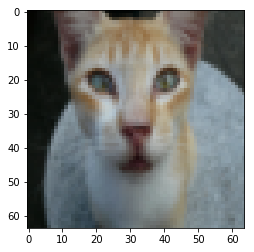

In [9]:
from utils import load_data
# Loading DataSet
train_x, train_Y, test_x, test_Y, classes = load_data()

# No. of Examples, Image Height, Image Width, no. of Channels(RBG)
print(f"Training Input Data {train_x.shape}")

# consist of 0/1, 1:if it's a cat else 0
print(f"Training labels{train_Y.shape}")

# Example
index =11
plt.imshow(train_x[index])


In [10]:
# Reshape each image to Vector, X to (Single_Vector 64*64*3,  no.of examples)
train_Xflat = train_x.reshape(-1, train_x.shape[0])
test_Xflat = test_x.reshape(-1, test_x.shape[0])

# Scaling pixel values b/w 0 to 1 
train_X = train_Xflat /255
test_X = test_Xflat /255

print(f"Training Data{train_X.shape}")
print(f"Test data{test_X.shape}")


Training Data(12288, 209)
Test data(12288, 50)


## 2.2 Defining Model

    1. Define Model Config(no. of layers and units in each layer)
    2. Initialize parameters
    3. Loop:
        a. Forward Propagation
        b. Compute Cost Function
        c. Backward Propagation
        d. Update parameters(W,b using cache values)
    4. Use parameters to predict labels

### Model Configuration
    layer[0]: Input layer (12288,?)
    layer[1]: 20 units with relu as Activation
    layer[2]: 7 units with relu as Activation 
    layer[3]: 5 units with relu as Activation 
    layer[4]: Output layer, 1 unit with sigmoid as Activation 

In [11]:
# Model Configuration
# len(layer_dims), will be no. of layers with Input & Output layers
layer_dims=[12288, 20, 7, 5, 1]

learning_rate=0.009

# No. of Gradient Descent Iterations
num_itr=300

In [12]:
def image_classifier(X, Y, layer_dims, learning_rate, num_itr, parameters, initialize=False):
    ''' Implements a L-layer NN: 
    [Linear->Relu] *(L-1)times  ->  [Linear->Sigmoid] 
    
    X: Input data(Images) (Height*Weidth*3 , no. of examples)
    Y: True labels, consist of 0/1      (1, no. of examples)
    layer_dims: list, where each value is no. of units.
    learning_rate: for parameters update
    num_itr: no. of iterations of Gradient Descent
    
    Returs:
    parameters: parameters learnt during Model Training.
    '''
    costs=[]
    
    if initialize:
        parameters = initialize_parameters(layer_dims)
    
   
    # Gradient Descent
    for i in range(num_itr):
        
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID
        y_hat, caches = L_layer_forward(X, parameters, layer_dims)

        # Compute Cost
        cost = compute_cost(y_hat, Y)

        # Backward propagation
        grads = L_layer_backward(y_hat, Y, caches, layer_dims)

        # Update Parameters
        parameters = update_params(parameters, grads, learning_rate)
        
        if i%200 ==0:
            print(f"cost {i}: {np.squeeze(cost)}")
        if i%100 ==0:
            costs.append(cost[0])

    # Ploting the Cost
    plt.plot(costs)
    plt.xlabel("n iteration")
    plt.ylabel("cost")
    
    return parameters

cost 0: 0.6905574738743139
cost 200: 0.6259687089377447
cost 400: 0.5491339571191219
cost 0: 0.5165736771011232
cost 200: 0.44000740507364766
cost 400: 0.41408147269860646
cost 0: 0.41267587248977683
cost 200: 0.3509585569849044
cost 400: 0.34337928409686364
cost 600: 0.33967454342915293
cost 800: 0.3061756591021378


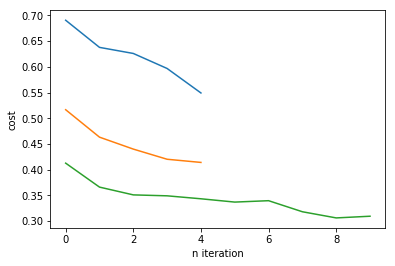

In [18]:
parameters=image_classifier(train_X, train_Y, layer_dims, 0.05, 500, 0, initialize=True)
parameters=image_classifier(train_X, train_Y, layer_dims, 0.009, 500, parameters, initialize=False)
parameters=image_classifier(train_X, train_Y, layer_dims, 0.005, 1000, parameters, initialize=False)

cost 0: 0.09455121331197718
cost 200: 0.08905332813952466
cost 400: 0.08371083394364122
cost 600: 0.0793367319090336
cost 800: 0.07536823660230452
cost 1000: 0.07197433309116627
cost 1200: 0.06872838900925801
cost 1400: 0.06625443634187707
cost 1600: 0.06437765728954029
cost 1800: 0.0620562741762558


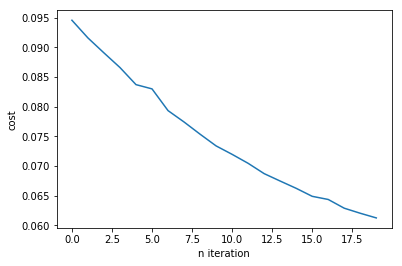

In [23]:
parameters = image_classifier(train_X, train_Y, layer_dims, 0.006, 2000, parameters, initialize=False)

In [24]:
# Caching Weights
import pickle
pickle.dump(parameters, open('parameters.pkl', 'wb'))
parameters=pickle.load(open("parameters.pkl", 'rb'))

In [25]:
# Defining predict function
def predict(X,Y, parameters):
    
    m= X.shape[1]
    # forward propagation
    y_hat, caches = L_layer_forward(X, parameters, layer_dims)
    
    y_hat=y_hat.reshape(-1)
    predicted=np.where(y_hat>0.5, 1, 0)
    
    accuracy = np.sum(predicted == Y) / m
     
    return(accuracy, predicted)
    

# Show Wrong predicted Images
def mislabel(X,Y,y_hat):
    xx = np.array(Y+y_hat)
    mislabel_index = (np.where(xx == 1))[1]
    return mislabel_index

Train Data Accuracy: 0.9856459330143541
Mislabel Index [105 131 139]


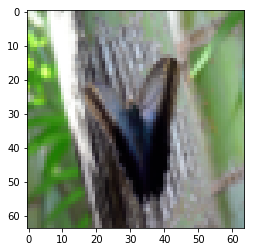

In [33]:
train_accuracy, train_predictedValues = predict(train_X, train_Y, parameters)
print(f"Train Data Accuracy: {train_accuracy}")
# More Accuracy can be obtain by training again at lower learning_rate

# Show Mislabeled Image
mislabel_index = mislabel(train_X,train_Y,train_predictedValues)
print("Mislabel Index", mislabel_index)

indexx =mislabel_index[1]
plt.imshow(train_x[indexx])
